See [README.md](https://github.com/druce/portfolio_optimization/blob/master/README.md) for discussion, environment setup


In [1]:
import os
import sys
from multiprocessing import Pool
from datetime import datetime
import time 
import requests
import dotenv

import numpy as np
import pandas as pd
import pandas_datareader as pdr
import xlrd

import scipy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, leaves_list
from scipy.spatial.distance import squareform

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

import openbb
from openbb import obb
from openbb_core.app.model.obbject import OBBject

# https://www.cvxpy.org/install/index.html
import cvxpy as cp

# https://riskfolio-lib.readthedocs.io/en/latest/
import riskfolio as rp

# set seed for reproducibility
np.random.seed(2347)

print("%-20s %s" % ('python', ".".join(map(str, sys.version_info[:3]))))
print("%-20s %s" % ("numpy", np.__version__))
print("%-20s %s" % ("scipy", scipy.__version__))

print("%-20s %s" % ("pandas", pd.__version__))
print("%-20s %s" % ("pandas-datareader", pdr.__version__))
# print("%-20s %s" % ("xlrd", xlrd.__version__))
print("%-20s %s" % ("seaborn", sns.__version__))
print("%-20s %s" % ("matplotlib", matplotlib.__version__))
print("%-20s %s" % ("cvxpy", cp.__version__))
print("%-20s %s" % ("openbb", obb.system.version))

print("%-20s %s" % ("riskfolio", rp.__version__))


python               3.11.11
numpy                1.26.4
scipy                1.14.1
pandas               2.2.3
pandas-datareader    0.10.0
seaborn              0.13.2
matplotlib           3.10.0
cvxpy                1.6.0
openbb               4.3.5
riskfolio            6.3.1


# Get data

In [2]:
# load spreadsheet from Damodaran website into pandas dataframe

# if below gives cert error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

data_xls = 'https://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls'
data_sheet = "Returns by year"
# these will change as rows get added on Damodaran website
skiprows = range(19)
skipfooter = 13
download_df = pd.read_excel(data_xls, 
                         sheet_name=data_sheet, 
                         skiprows=skiprows,
                         skipfooter=skipfooter)
download_df


,Year,S&P 500 (includes dividends),US Small cap (bottom decile),3-month T.Bill,US T. Bond (10-year),Baa Corporate Bond,Real Estate,Gold*,S&P 500 (includes dividends)3,US Small cap (bottom decile) Cum Value,...,Gold,S&P 500 (includes dividends)3.1,US Small cap (bottom decile)22.1,3-month T.Bill4.1,US T. Bond5.1,Baa Corporate Bond2.1,Real Estate2.1,Gold2.1,Stocks minus T. Bills,Stocks minus T.Bonds
0,1928,0.438112,0.5991,0.030800,0.008355,0.032196,0.014911,0.000969,143.811155,1.599100e+02,...,0.012676,145.493158,161.780293,104.285615,102.014834,104.426798,102.678084,101.267624,0.412075,0.434783
1,1929,-0.082979,-0.4661,0.031600,0.042038,0.030179,-0.020568,-0.001452,131.877782,8.537595e+01,...,-0.007258,132.644508,85.872317,106.955564,105.685290,106.952789,99.981502,100.532660,-0.113913,-0.124291
2,1930,-0.251236,-0.5003,0.045500,0.045409,0.005398,-0.043000,0.000969,98.745288,4.266236e+01,...,0.069359,106.105182,45.842164,119.462059,118.033011,114.876878,102.219599,107.505474,-0.317010,-0.316913
3,1931,-0.438375,-0.4466,0.023100,-0.025589,-0.156808,-0.081505,-0.173850,55.457774,2.360935e+01,...,-0.088971,65.713662,27.975463,134.778649,126.829091,106.815001,103.534271,97.940557,-0.508887,-0.455197
4,1932,-0.086424,0.2049,0.010700,0.087903,0.235896,-0.104664,0.212778,50.664911,2.844691e+01,...,0.351646,66.908619,37.567287,151.818576,153.776732,147.128135,103.312182,132.380976,-0.108245,-0.194288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,2020,0.180232,0.3473,0.003547,0.113319,0.106012,0.104266,0.241694,592914.798591,4.306129e+06,...,0.225009,39379.864970,286001.909604,139.282860,592.503127,3531.986222,266.622464,608.536643,0.174310,0.066014
93,2021,0.284689,0.2169,0.000450,-0.044160,0.009334,0.188646,-0.037544,761710.833617,5.240128e+06,...,-0.100815,47265.098928,325156.417627,130.185213,529.107841,3330.600950,296.085994,547.187283,0.265553,0.307231
94,2022,-0.180375,-0.2338,0.020248,-0.178282,-0.151441,0.056518,0.005494,624317.196856,4.014986e+06,...,-0.055470,36390.843316,234029.638217,124.768141,408.416737,2654.857034,293.853809,516.835040,-0.188459,-0.001966
95,2023,0.260607,0.0517,0.050704,0.038800,0.087357,0.056784,0.132621,787018.534835,4.222561e+06,...,0.095886,44386.652501,238146.029818,126.842427,410.502762,2793.147002,300.467972,566.392162,0.203095,0.214613


In [3]:
# set index to year as int
download_df["Year"] = download_df["Year"].astype(int)
download_df.set_index(download_df["Year"], inplace=True)
download_df


,Year,S&P 500 (includes dividends),US Small cap (bottom decile),3-month T.Bill,US T. Bond (10-year),Baa Corporate Bond,Real Estate,Gold*,S&P 500 (includes dividends)3,US Small cap (bottom decile) Cum Value,...,Gold,S&P 500 (includes dividends)3.1,US Small cap (bottom decile)22.1,3-month T.Bill4.1,US T. Bond5.1,Baa Corporate Bond2.1,Real Estate2.1,Gold2.1,Stocks minus T. Bills,Stocks minus T.Bonds
Year,,,,,,,,,,,,,,,,,,,,,
1928,1928,0.438112,0.5991,0.030800,0.008355,0.032196,0.014911,0.000969,143.811155,1.599100e+02,...,0.012676,145.493158,161.780293,104.285615,102.014834,104.426798,102.678084,101.267624,0.412075,0.434783
1929,1929,-0.082979,-0.4661,0.031600,0.042038,0.030179,-0.020568,-0.001452,131.877782,8.537595e+01,...,-0.007258,132.644508,85.872317,106.955564,105.685290,106.952789,99.981502,100.532660,-0.113913,-0.124291
1930,1930,-0.251236,-0.5003,0.045500,0.045409,0.005398,-0.043000,0.000969,98.745288,4.266236e+01,...,0.069359,106.105182,45.842164,119.462059,118.033011,114.876878,102.219599,107.505474,-0.317010,-0.316913
1931,1931,-0.438375,-0.4466,0.023100,-0.025589,-0.156808,-0.081505,-0.173850,55.457774,2.360935e+01,...,-0.088971,65.713662,27.975463,134.778649,126.829091,106.815001,103.534271,97.940557,-0.508887,-0.455197
1932,1932,-0.086424,0.2049,0.010700,0.087903,0.235896,-0.104664,0.212778,50.664911,2.844691e+01,...,0.351646,66.908619,37.567287,151.818576,153.776732,147.128135,103.312182,132.380976,-0.108245,-0.194288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,2020,0.180232,0.3473,0.003547,0.113319,0.106012,0.104266,0.241694,592914.798591,4.306129e+06,...,0.225009,39379.864970,286001.909604,139.282860,592.503127,3531.986222,266.622464,608.536643,0.174310,0.066014
2021,2021,0.284689,0.2169,0.000450,-0.044160,0.009334,0.188646,-0.037544,761710.833617,5.240128e+06,...,-0.100815,47265.098928,325156.417627,130.185213,529.107841,3330.600950,296.085994,547.187283,0.265553,0.307231
2022,2022,-0.180375,-0.2338,0.020248,-0.178282,-0.151441,0.056518,0.005494,624317.196856,4.014986e+06,...,-0.055470,36390.843316,234029.638217,124.768141,408.416737,2654.857034,293.853809,516.835040,-0.188459,-0.001966


In [4]:
# download GDP for correlation matrix
series = ['GDPCA']

gdp_download = pdr.data.DataReader(series, 
                                   'fred', 
                                   start='1926-12-31')
gdp_download.reset_index(inplace=True)
gdp_download.set_index(pd.DatetimeIndex(gdp_download['DATE']).year, inplace=True)
gdp_download['GDP'] = gdp_download['GDPCA'].pct_change()
# https://fortunly.com/statistics/us-gdp-by-year-guide/#gref
gdp_download.loc[1928, 'GDP'] = 0.0110
gdp_download.loc[1929, 'GDP'] = 0.0652
gdp_download.sort_index(inplace=True)
gdp_download.to_csv('gdp_fred.csv')

gdp_download

,DATE,GDPCA,GDP
DATE,,,
1928,NaT,NaN,0.011000
1929,1929-01-01,1191.124,0.065200
1930,1930-01-01,1089.785,-0.085078
1931,1931-01-01,1019.977,-0.064057
1932,1932-01-01,888.414,-0.128986
...,...,...,...
2019,2019-01-01,20715.671,0.025838
2020,2020-01-01,20267.585,-0.021630
2021,2021-01-01,21494.798,0.060551


In [5]:
real_data_df = download_df.copy()
real_data_df.columns

Index(['Year', 'S&P 500 (includes dividends)', 'US Small cap (bottom decile)',
       '3-month T.Bill', 'US T. Bond (10-year)', ' Baa Corporate Bond',
       'Real Estate', 'Gold*', 'S&P 500 (includes dividends)3',
       'US Small cap (bottom decile) Cum Value', '3-month T.Bill4',
       'US T. Bond5', ' Baa Corporate Bond2', 'Real Estate2', 'Gold2',
       'Stocks - Bills', 'Stocks - Bonds',
       'Small Cap Premium (S&P 500 minus Bottom Decile)',
       'Stocks - Baa Corp Bond', 'Historical ERP', 'Inflation Rate',
       'S&P 500 (includes dividends)2', 'US Small cap (bottom decile)22',
       '3-month T. Bill (Real)', '!0-year T.Bonds', 'Baa Corp Bonds',
       'Real Estate3', 'Gold', 'S&P 500 (includes dividends)3.1',
       'US Small cap (bottom decile)22.1', '3-month T.Bill4.1',
       'US T. Bond5.1', ' Baa Corporate Bond2.1', 'Real Estate2.1', 'Gold2.1',
       'Stocks minus T. Bills', 'Stocks minus T.Bonds'],
      dtype='object')

In [6]:
# use caution to grab real return columns, not nominal, column names are similar
# check values vs. sheet
real_data_df = download_df.copy()
real_data_df = real_data_df.drop(columns=["Real Estate"])
real_data_df = real_data_df.rename(
    columns={
        "Real Estate": "Real Estate (nominal)",
        'Inflation Rate': 'CPI',
        'S&P 500 (includes dividends)2': 'S&P',
        "US Small cap (bottom decile)22": "Small Caps",
        '!0-year T.Bonds': 'T-Notes',
        '3-month T. Bill (Real)': 'T-Bills',
        'Baa Corp Bonds': 'Baa Corps',
        'Real Estate3': 'Real Estate',
    })

real_data_df["GDP"] = gdp_download['GDP']
# filter and reorder
real_data_df = real_data_df[[
    'GDP',
    'CPI',
    'S&P',
    'Small Caps',
    'T-Bills',
    'T-Notes',
    'Baa Corps',
    'Real Estate',
    'Gold',
]]
real_data_df

,GDP,CPI,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,,,
1928,0.011000,-0.011561,0.454932,0.617803,0.042856,0.020148,0.044268,0.026781,0.012676
1929,0.065200,0.005848,-0.088311,-0.469204,0.025602,0.035980,0.024189,-0.026262,-0.007258
1930,-0.085078,-0.063953,-0.200079,-0.466159,0.116932,0.116835,0.074090,0.022385,0.069359
1931,-0.064057,-0.093168,-0.380674,-0.389744,0.128213,0.074522,-0.070178,0.012861,-0.088971
1932,-0.128986,-0.102740,0.018184,0.342866,0.126429,0.212472,0.377411,-0.002145,0.351646
...,...,...,...,...,...,...,...,...,...
2020,-0.021630,0.013620,0.164373,0.329196,-0.009937,0.098359,0.091150,0.089428,0.225009
2021,0.060551,0.070364,0.200235,0.136903,-0.065318,-0.106996,-0.057018,0.110507,-0.100815
2022,0.025124,0.064544,-0.230069,-0.280255,-0.041611,-0.228103,-0.202889,-0.007539,-0.055470


In [7]:
cumreturns = (1 + real_data_df.copy()).cumprod()
(cumreturns.iloc[-1]-1)**(1/len(cumreturns))-1


GDP                 NaN
CPI            0.029775
S&P            0.066980
Small Caps     0.084456
T-Bills       -0.012478
T-Notes        0.011143
Baa Corps      0.034425
Real Estate    0.007420
Gold           0.018543
Name: 2024, dtype: float64

In [8]:
# check gold data v MacroTrends
# gdf = pd.read_csv('MacroTrends_Data_Download.csv')
# gdf["Year"] = pd.to_datetime(gdf['date'])
# gdf = gdf.loc[gdf["Year"].dt.month ==12]
# gdf["Year"] = gdf["Year"].dt.year
# gdf = gdf.set_index("Year", drop=True)
# gdf['real_pct'] = gdf["real"].pct_change()
# gdf['nom_pct'] = gdf["nominal"].pct_change()
# gdf["damodaran_real_pct"]=download_df["Gold"]
# gdf["damodaran_nom_pct"]=download_df["Gold*"]
# gdf["real_diff"] = gdf["damodaran_real_pct"]-gdf["real_pct"]
# gdf["nom_diff"] = gdf["damodaran_nom_pct"]-gdf["nom_pct"]
# gdf[["nom_diff", 'real_diff']].plot()

# Visualize

In [9]:
pd.set_option('display.max_rows', None)  # display all rows without truncation


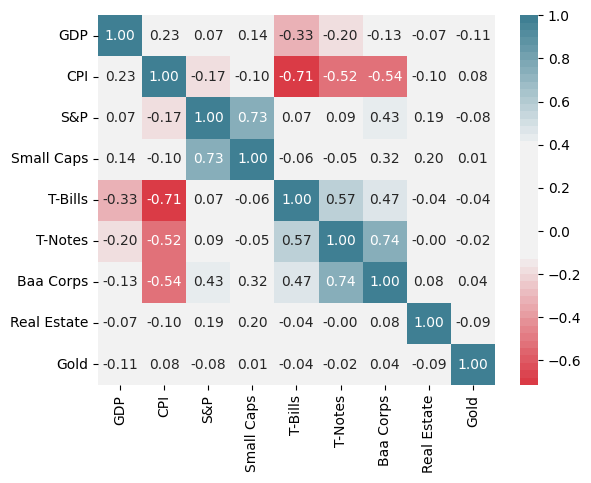

In [10]:
for col in real_data_df.columns:
    real_data_df[col] = real_data_df[col].astype(float)

# compute correlation matrix
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(real_data_df.corr(), annot=True, fmt=".02f", cmap=my_cmap);


In [11]:
# drop CPI, GDP which are not assets
try:
    real_data_df.drop(labels=['CPI', 'GDP'], axis=1, inplace=True)
except:
    pass
    
df = real_data_df.copy()
df.head()


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,
1928,0.454932,0.617803,0.042856,0.020148,0.044268,0.026781,0.012676
1929,-0.088311,-0.469204,0.025602,0.035980,0.024189,-0.026262,-0.007258
1930,-0.200079,-0.466159,0.116932,0.116835,0.074090,0.022385,0.069359
1931,-0.380674,-0.389744,0.128213,0.074522,-0.070178,0.012861,-0.088971
1932,0.018184,0.342866,0.126429,0.212472,0.377411,-0.002145,0.351646


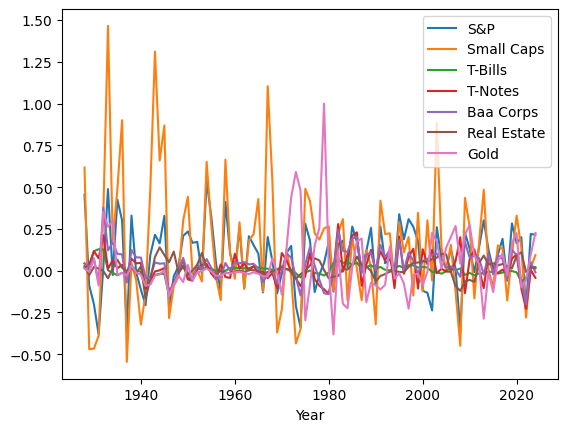

In [12]:
df.plot.line();


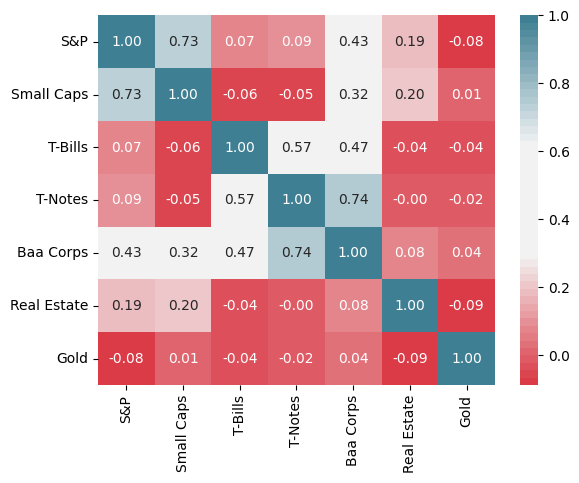

In [13]:
# compute correlation matrix
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(df.corr(), annot=True, fmt=".02f", cmap=my_cmap);


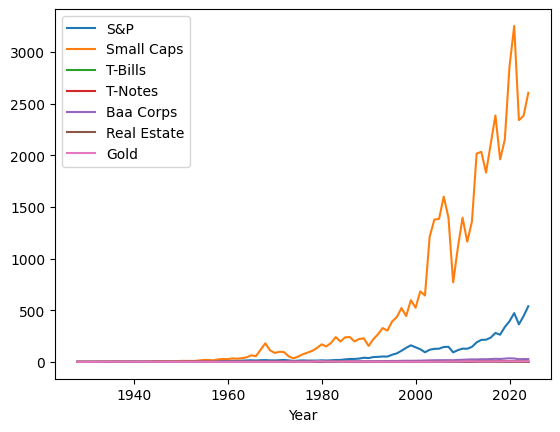

In [14]:
# plot historical cumulative growth
df2 = df.copy()
for col in df2.columns:
    df2[col]+= 1
    df2[col] = df2[col].cumprod()
    
df2.plot.line();


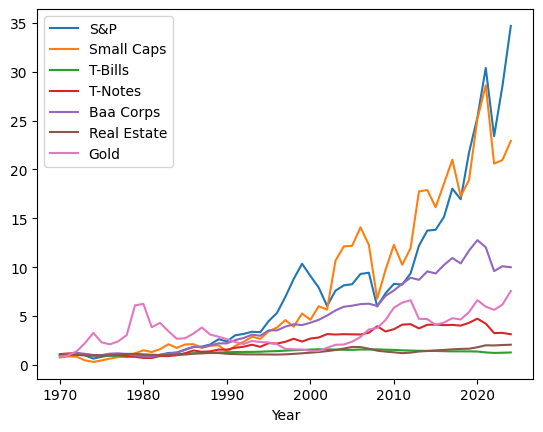

In [15]:
# plot historical cumulative growth since 1970
df2 = df.copy().loc[1970:]
for col in df2.columns:
    df2[col]+= 1
    df2[col] = df2[col].cumprod()
    
df2.plot.line();


In [16]:
labels = list(df.columns)
labels


['S&P', 'Small Caps', 'T-Bills', 'T-Notes', 'Baa Corps', 'Real Estate', 'Gold']

# Long-only optimization

## 1928 - present 

In [17]:
# arithmetic means
df.mean()

S&P            0.085485
Small Caps     0.141503
T-Bills        0.003392
T-Notes        0.018030
Baa Corps      0.038531
Real Estate    0.012791
Gold           0.034768
dtype: float64

In [18]:
# geometric mean
cumreturns = (1 + df.copy()).cumprod()
(cumreturns.iloc[-1]-1)**(1/len(cumreturns))-1
# difference due to volatility and compounding and maybe divergences from IID log normal distribution


S&P            0.066980
Small Caps     0.084456
T-Bills       -0.012478
T-Notes        0.011143
Baa Corps      0.034425
Real Estate    0.007420
Gold           0.018543
Name: 2024, dtype: float64

In [19]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
rows,,,,,,,
real return,0.085485,0.141503,0.003392,0.018030,0.038531,0.012791,0.034768
vol,0.193954,0.372034,0.038017,0.088987,0.088440,0.049934,0.186131


In [20]:
w

Variable((7,), var1)

In [21]:
Sigma

array([[ 3.76179626e-02,  5.26025231e-02,  4.89273958e-04,
         1.55275663e-03,  7.37028336e-03,  1.84774960e-03,
        -2.96149255e-03],
       [ 5.26025231e-02,  1.38409587e-01, -8.67773938e-04,
        -1.55508530e-03,  1.04145497e-02,  3.63592264e-03,
         8.34278803e-04],
       [ 4.89273958e-04, -8.67773938e-04,  1.44531670e-03,
         1.92002350e-03,  1.59192519e-03, -7.34199533e-05,
        -2.48476504e-04],
       [ 1.55275663e-03, -1.55508530e-03,  1.92002350e-03,
         7.91860828e-03,  5.81698998e-03, -1.10980376e-05,
        -2.71209124e-04],
       [ 7.37028336e-03,  1.04145497e-02,  1.59192519e-03,
         5.81698998e-03,  7.82171390e-03,  3.46499059e-04,
         6.71323493e-04],
       [ 1.84774960e-03,  3.63592264e-03, -7.34199533e-05,
        -1.10980376e-05,  3.46499059e-04,  2.49337623e-03,
        -8.14979643e-04],
       [-2.96149255e-03,  8.34278803e-04, -2.48476504e-04,
        -2.71209124e-04,  6.71323493e-04, -8.14979643e-04,
         3.4644598

In [22]:
# Solve max return portfolio (corner solution)
# should be 100% stocks
prob = cp.Problem(cp.Maximize(ret),      # maximize return
                  [cp.sum(w) == 1,       # weights sum to 1
                   w >= 0]               # each w > 0
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)
# all stocks which is highest return asset

Max return portfolio weights


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# solve min vol portfolio (other corner solution)
# should be mostly T-bills but there is variance in t-bills so it diversifies
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1,     # weights sum to 1
                   w >= 0],            # each weight >= 0
                 )
prob.solve()
# round to not get x.xxxxE-22
wts = [float('%0.6f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)
# mostly t-bills and real estate

Min vol portfolio weights


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
0,0.000007,0.000018,0.600014,0.0,0.000002,0.363117,0.036843


In [24]:
# %%time
# solve points in between
# for a series of points between min and max vol, maximize return subject to volatility constraints 

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(np.sqrt(minvol), np.sqrt(maxretvol), NPOINTS)
vl_vals = np.square(vl_vals)
# vol constraint is in variance space, take square root of minvol and maxvol, linspace, square values)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


In [25]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]


In [26]:
ret_df

,i,vol,return,std,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
0,0,0.000831,0.007977,0.028834,5.238039e-08,0.000089,5.997808e-01,3.248378e-09,3.661614e-09,3.632161e-01,3.691400e-02
1,1,0.000934,0.012703,0.030558,3.165212e-02,0.004547,5.104928e-01,1.745685e-08,2.448912e-02,3.745173e-01,5.430186e-02
2,2,0.001042,0.014971,0.032283,4.116687e-02,0.005571,4.565727e-01,7.685397e-08,5.565757e-02,3.805541e-01,6.047805e-02
3,3,0.001157,0.016821,0.034008,4.891573e-02,0.006407,4.125819e-01,1.000659e-07,8.109268e-02,3.854947e-01,6.550801e-02
4,4,0.001277,0.018453,0.035732,5.574410e-02,0.007154,3.737262e-01,2.128841e-07,1.035227e-01,3.899129e-01,6.993939e-02
5,5,0.001403,0.019950,0.037457,6.202399e-02,0.007824,3.381966e-01,3.844838e-07,1.241220e-01,3.938069e-01,7.402593e-02
6,6,0.001535,0.021353,0.039182,6.789446e-02,0.008462,3.048460e-01,6.311019e-07,1.434204e-01,3.975333e-01,7.784366e-02
7,7,0.001673,0.022687,0.040906,7.350998e-02,0.009061,2.730896e-01,5.963779e-08,1.617023e-01,4.011702e-01,8.146716e-02
8,8,0.001817,0.023968,0.042631,7.886677e-02,0.009642,2.426399e-01,5.692560e-08,1.793467e-01,4.045487e-01,8.495627e-02
9,9,0.001967,0.025208,0.044355,8.405845e-02,0.010204,2.131718e-01,9.269942e-08,1.963865e-01,4.078505e-01,8.832891e-02


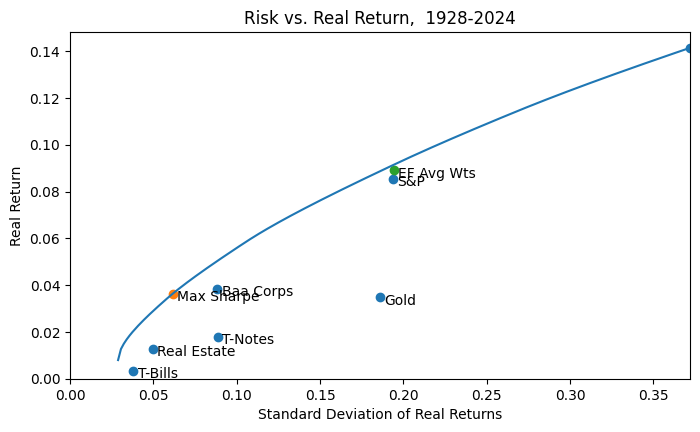

Max Sharpe Portfolio:
Real Return: 3.63%
SD:          6.16%
T-Bills: 0.0%
Real Estate: 39.3%
T-Notes: 0.0%
Baa Corps: 33.3%
Gold: 11.9%
S&P: 13.5%
Small Caps: 2.0%

Average over efficient frontier:
Real Return: 8.91%
SD:          19.42%
T-Bills: 2.2%
Real Estate: 6.4%
T-Notes: 0.0%
Baa Corps: 12.9%
Gold: 9.2%
S&P: 32.1%
Small Caps: 37.1%
Real Return: 8.91%
SD:          19.42%


In [27]:
# plot efficient frontier
def plot_efrontier(ret_df, df,
                   xlabel="Standard Deviation of Real Returns",
                   ylabel="Real Return",
                   title=None):

    Sigma = np.cov(df.transpose())
    n = Sigma.shape[0]
    mu = df.mean().values
    asset_vols = np.sqrt(Sigma.diagonal())

    risk_free_rate = 0
    ret_df["Sharpe"] = (ret_df["return"] - risk_free_rate) / ret_df["std"]
    max_sharpe_index = ret_df["Sharpe"].argmax()
#     print(max_sharpe_index)
    max_sharpe_return = ret_df.iloc[max_sharpe_index]["return"]
#     print(max_sharpe_return)
    max_sharpe_std = ret_df.iloc[max_sharpe_index]["std"]
#     print(max_sharpe_std)
    
    asset_names = [t for t in ['TIPS', 'T-Bills', 'Real Estate', 'T-Notes', 'Baa Corps', 'Gold', 'S&P', 'Small Caps', 'shorts'] if t in ret_df.columns]
    
    mean_wts = ret_df[asset_names].mean() # average weights over all efficient portolios
    temp_ret_df = df[asset_names]         # historical returns
    avg_ret = temp_ret_df @ mean_wts.values
    avg_ret_mean = avg_ret.mean()
    avg_ret_std = avg_ret.std()
    
    plt.figure(figsize=(8, 4.5))

    # plot the data
    plt.plot(ret_df['std'], ret_df['return'])
    # Force both axes to start at 0
    plt.xlim(left=0, right=max(asset_vols))
    plt.ylim(bottom=0)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plot_title = "Risk vs. Real Return,  %d-%d" % (df.index[0], df.index[-1]) if title is None else title
    plt.title(plot_title)

    # plot the markers
    plt.scatter(asset_vols, mu)
    xoffset = 0.0025
    yoffset = 0.0015
    labels = df.columns
    for i, label in enumerate(labels):
        plt.annotate(label, xy=(asset_vols[i]+xoffset, mu[i]+yoffset), xycoords='data',
                     horizontalalignment='left', verticalalignment='top',
                    )
    plt.scatter([max_sharpe_std], [max_sharpe_return])
    plt.annotate("Max Sharpe", xy=(max_sharpe_std+xoffset, max_sharpe_return+yoffset), xycoords='data',
                 horizontalalignment='left', verticalalignment='top',
                )
    plt.scatter([avg_ret_std], [avg_ret_mean])
    plt.annotate("EF Avg Wts", xy=(avg_ret_std+xoffset, avg_ret_mean+yoffset), xycoords='data',
                 horizontalalignment='left', verticalalignment='top',
                )
    plt.show()
    

    print("Max Sharpe Portfolio:")
    print(f"Real Return: {100*max_sharpe_return:3.2f}%")
    print(f"SD:          {100*max_sharpe_std:3.2f}%")

    for col in asset_names:
        print(f"{col}: {100*ret_df.iloc[max_sharpe_index][col]:3.1f}%")
  
    print()
    print("Average over efficient frontier:")
    print(f"Real Return: {100*avg_ret.mean():3.2f}%")
    print(f"SD:          {100*avg_ret.std():3.2f}%")
    for col in asset_names:
        print(f"{col}: {100*mean_wts[col]:3.1f}%")
    print(f"Real Return: {100*avg_ret_mean:3.2f}%")
    print(f"SD:          {100*avg_ret_std:3.2f}%")
            
    return max_sharpe_return, max_sharpe_std, avg_ret_mean, avg_ret_std
        
max_sharpe_return, max_sharpe_std, avg_ret_mean, avg_ret_std = plot_efrontier(ret_df, df)


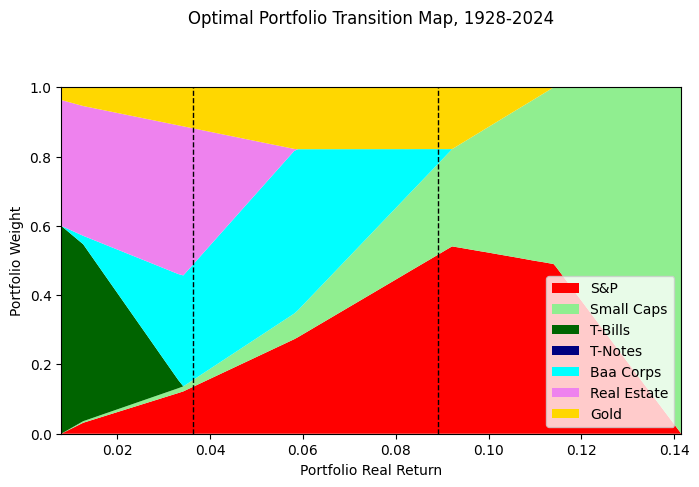

In [28]:
# stacked area chart of weights vs. returns
# for given vol constraint and corresponding real return, show portfolio weights
def transition_map(ret_df, labels, startyear, endyear, max_sharpe_return=None, avg_ret_mean=None, ylim=1):
    
    x = ret_df['return']
    # absolute values so shorts don't create chaos
    y_list = [abs(ret_df[l]) for l in labels]
    pal = ['red', 'lightgreen', 'darkgreen', 'navy', 'cyan', 'violet', 'gold', ]
    
    fig = plt.figure(figsize=(8, 4.5))
    ax1 = fig.add_subplot(111)
  
    ax1.stackplot(x, y_list, labels=labels, colors=pal)
    ax1.set_xlim((ret_df['return'].iloc[0], ret_df['return'].iloc[-1]))
    ax1.set_ylim((0, ylim))
    ax1.set_xlabel('Portfolio Vol')
    ax1.set_xlabel("Portfolio Real Return")
    ax1.set_ylabel("Portfolio Weight")
    ax1.legend(loc='lower right')
#     return/std relationship is not linear, can't have both axes
#     ax2 = ax1.twiny()
#     ax2.set_xlim((ret_df['std'].iloc[0], ret_df['std'].iloc[-1]))
#     ax2.set_xlabel('Portfolio Vol')
    
    if max_sharpe_return is not None:
        ax1.axvline(max_sharpe_return, color='black', linestyle='--', linewidth=1)
    
    if max_sharpe_return is not None:
        ax1.axvline(avg_ret_mean, color='black', linestyle='--', linewidth=1)
        
    plt.title("Optimal Portfolio Transition Map, %d-%d" % (startyear, endyear), y=1.16);

transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1], max_sharpe_return=max_sharpe_return, avg_ret_mean=avg_ret_mean)


## 1967 - present (more inflationary era including post gold standard)

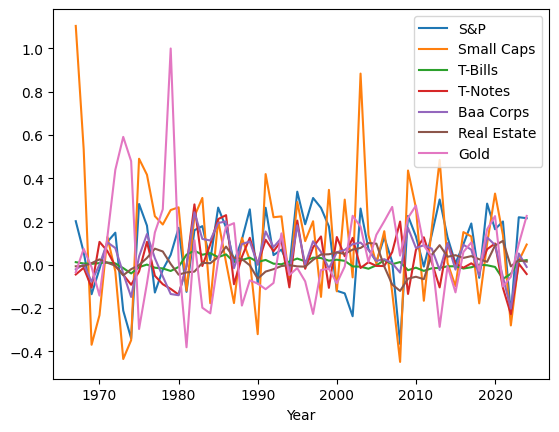

In [29]:
df = real_data_df.loc[1967:]
df.plot.line();


In [30]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
rows,,,,,,,
real return,0.078913,0.106745,0.004907,0.022054,0.042677,0.013703,0.057335
vol,0.166909,0.294522,0.024796,0.103460,0.090564,0.049132,0.225311


In [31]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)


Max return portfolio weights


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
0,-0.0,0.0,0.7474,-0.0,-0.0,0.2119,0.0407


In [33]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(np.sqrt(minvol), np.sqrt(maxretvol), NPOINTS)
vl_vals = np.square(vl_vals)
# vol constraint is in variance space, take square root of minvol and maxvol, linspace, square values)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 280 ms, sys: 12.1 ms, total: 292 ms
Wall time: 95.4 ms


In [34]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
# ret_df

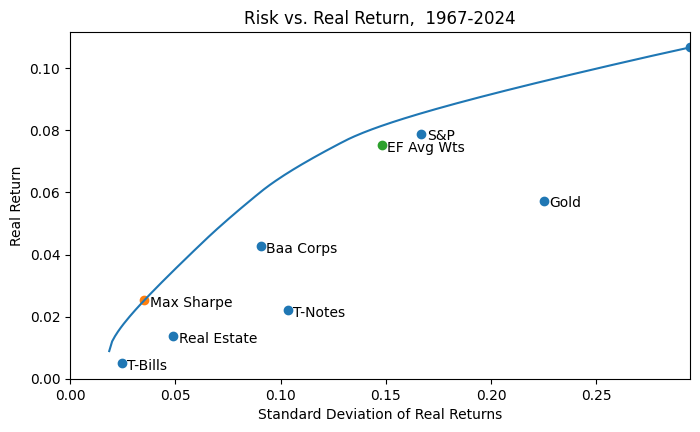

Max Sharpe Portfolio:
Real Return: 2.53%
SD:          3.53%
T-Bills: 41.2%
Real Estate: 25.1%
T-Notes: 0.0%
Baa Corps: 14.0%
Gold: 10.1%
S&P: 8.2%
Small Caps: 1.5%

Average over efficient frontier:
Real Return: 7.52%
SD:          14.81%
T-Bills: 5.6%
Real Estate: 5.6%
T-Notes: 0.0%
Baa Corps: 9.5%
Gold: 14.1%
S&P: 27.4%
Small Caps: 37.8%
Real Return: 7.52%
SD:          14.81%


In [35]:
max_sharpe_return, max_sharpe_std, avg_ret_mean, avg_ret_std = plot_efrontier(ret_df, df)


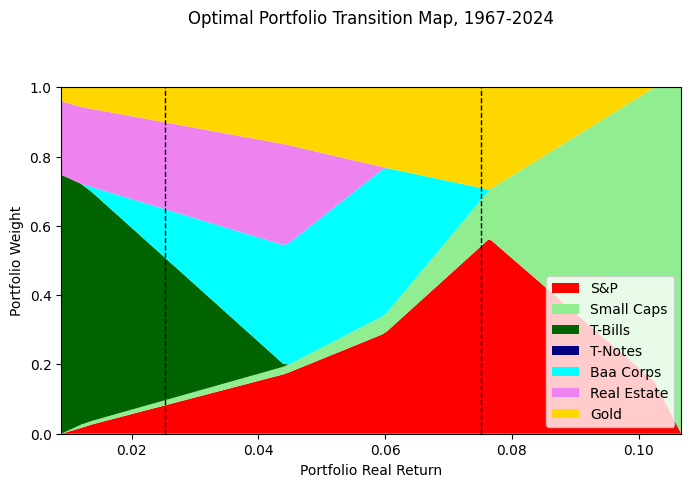

In [36]:
transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1], max_sharpe_return=max_sharpe_return, avg_ret_mean=avg_ret_mean)


## 1983 - present (era of globalization, post-big inflation)


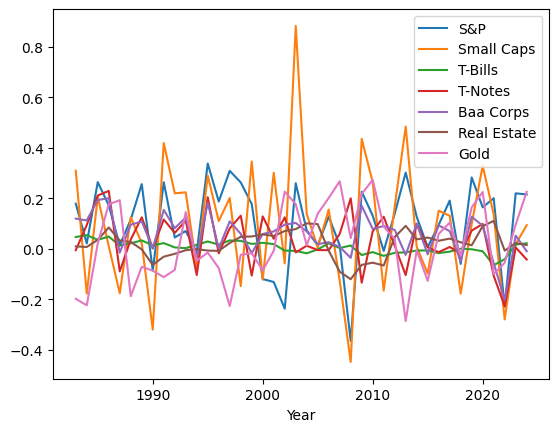

In [37]:
df = real_data_df.loc[1983:]
df.plot.line();

In [38]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
rows,,,,,,,
real return,0.100178,0.092881,0.006177,0.034783,0.058559,0.018578,0.024302
vol,0.161521,0.247987,0.024511,0.100736,0.079567,0.053122,0.148361


In [39]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)


Max return portfolio weights


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
0,0.0,0.0,0.7549,-0.0,-0.0,0.1916,0.0535


In [41]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(np.sqrt(minvol), np.sqrt(maxretvol), NPOINTS)
vl_vals = np.square(vl_vals)
# vol constraint is in variance space, take square root of minvol and maxvol, linspace, square values)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 272 ms, sys: 3.44 ms, total: 275 ms
Wall time: 92 ms


In [42]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
# ret_df


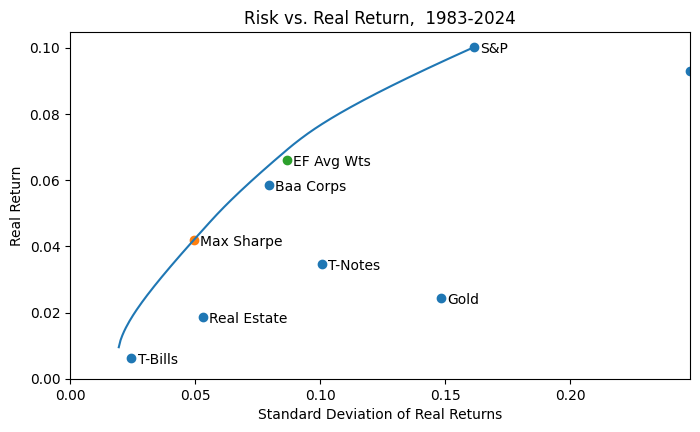

Max Sharpe Portfolio:
Real Return: 4.19%
SD:          4.95%
T-Bills: 11.9%
Real Estate: 31.5%
T-Notes: 0.0%
Baa Corps: 40.4%
Gold: 5.9%
S&P: 10.2%
Small Caps: 0.0%

Average over efficient frontier:
Real Return: 6.60%
SD:          8.68%
T-Bills: 8.6%
Real Estate: 10.8%
T-Notes: 0.0%
Baa Corps: 36.5%
Gold: 2.7%
S&P: 41.4%
Small Caps: 0.0%
Real Return: 6.60%
SD:          8.68%


In [43]:
max_sharpe_return, max_sharpe_std, avg_ret_mean, avg_ret_std = plot_efrontier(ret_df, df)


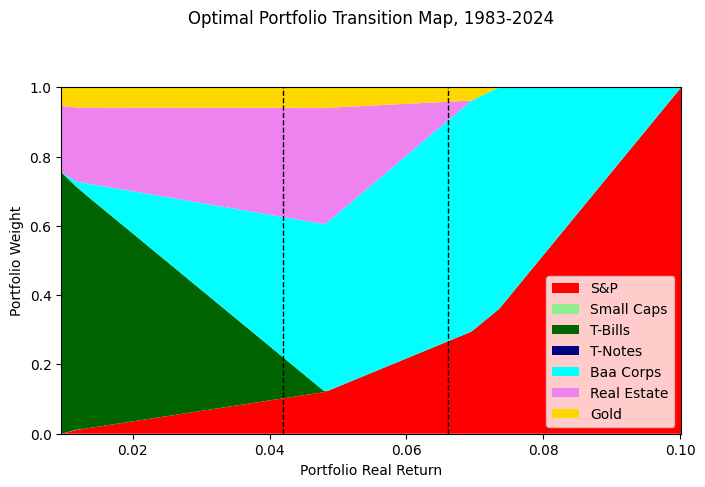

In [44]:
transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1], max_sharpe_return=max_sharpe_return, avg_ret_mean=avg_ret_mean)


## Add a risk-free asset
- The efficient frontier above does not include a risk-free asset, when we inflation-adjust t-bill returns we get volatility and fluctuation in returns including periods of negative real returns.
- However TIPS are available which offer a guaranteed real pre-tax return. They are issued at a real rate, the principal gets adjusted for inflation, and if there is deflation you can't get back less than par. So when you buy TIPS you are guaranteed a positive real pre-tax return
- TIPS offer an inflation hedge and a safe real return, so they might dominate gold. There isn't a great theoretical argument gold should increase in value faster than inflation in the long run (gold bugs might disagree but in a fiat world, that's my story and I'm sticking to it). I could see reasonable arguments why gold should maintain its real value if supply is fixed, and there should be demand for gold when there is inflation and people lose faith in monetary authorities because it is currency-like and supply is relatively fixed, so gold offers an inflation hedge. 
- TIPS total returns are only available for approximately the last 25 years. You can model the TIPS yield as the yield on similar nominal Treasuries less inflation expectations. Hypothetically, there might be a sound way to model historical inflation expectations using recent inflation trends, gold, steepness of yield curve etc. And from there, model what TIPS total returns would theoretically have been based on Treasury total returns and changes in inflation expectations, but that is a challenge. We could also say that the best inflation hedge was gold up to 2000 and TIPS thereafter and use VIPSX OR TIP, but that is a kinky Franken-asset.
- We could also say that given the existence of TIPS, a risk-free 0 real yield asset is available. Worst case TIPS return is 0, if auction rate is 0. Or you could buy TIPS and donate any return over 0, and you are guaranteed return of principal plus inflation. You could argue that it wasn't available and if it had been then it would have modified other returns. If my aunt had wheels she'd be a bicycle.
- Lets posit that we are justified in adding a risk-free TIPS asset, with a constant zero return.
- In the real world you would get a positive real return on TIPS with some fluctuations, real TIPS should dominate the risk-free asset. So this model might underweight TIPS.


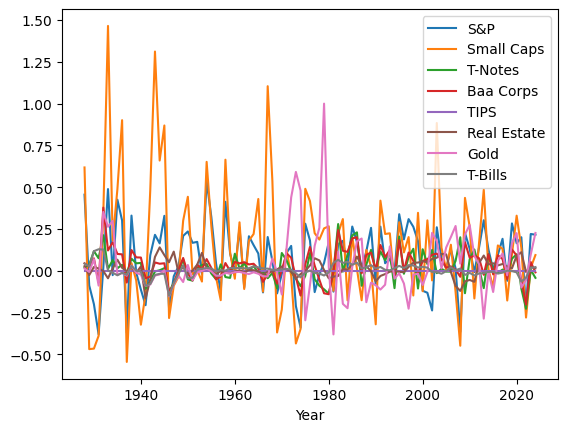

In [45]:
df = real_data_df.loc[1928:].copy()
df["TIPS"] = 0
# reorder  for chart
df = df[[ 'S&P', 'Small Caps', 'T-Notes', 'Baa Corps', 'TIPS', 'Real Estate', 'Gold', 'T-Bills' ]]
labels = df.columns
df.plot.line();

In [46]:
# compute covariance matrix
Sigma = np.cov(df.transpose())

# number of assets
n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 

# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,Small Caps,T-Notes,Baa Corps,TIPS,Real Estate,Gold,T-Bills
rows,,,,,,,,
real return,0.085485,0.141503,0.018030,0.038531,0.0,0.012791,0.034768,0.003392
vol,0.193954,0.372034,0.088987,0.088440,0.0,0.049934,0.186131,0.038017


In [47]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)


Max return portfolio weights


,S&P,Small Caps,T-Notes,Baa Corps,TIPS,Real Estate,Gold,T-Bills
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)



Min vol portfolio weights


,S&P,Small Caps,T-Notes,Baa Corps,TIPS,Real Estate,Gold,T-Bills
0,-0.0,-0.0,0.0,0.0,1.0,-0.0,0.0,0.0


In [49]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(np.sqrt(minvol), np.sqrt(maxretvol), NPOINTS)
vl_vals = np.square(vl_vals)
# vol constraint is in variance space, take square root of minvol and maxvol, linspace, square values)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 287 ms, sys: 6.8 ms, total: 293 ms
Wall time: 106 ms


In [50]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
# ret_df



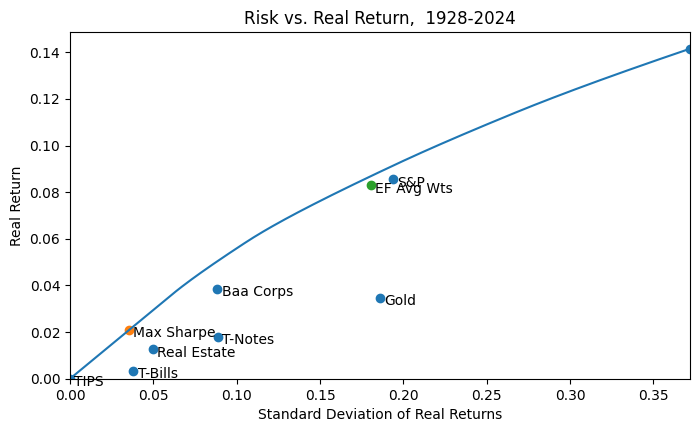

Max Sharpe Portfolio:
Real Return: 2.10%
SD:          3.55%
TIPS: 41.9%
T-Bills: 0.0%
Real Estate: 23.1%
T-Notes: 0.0%
Baa Corps: 19.3%
Gold: 6.8%
S&P: 7.8%
Small Caps: 1.1%

Average over efficient frontier:
Real Return: 8.30%
SD:          18.05%
TIPS: 8.4%
T-Bills: 0.0%
Real Estate: 5.5%
T-Notes: 0.0%
Baa Corps: 12.9%
Gold: 8.7%
S&P: 30.0%
Small Caps: 34.4%
Real Return: 8.30%
SD:          18.05%


In [51]:
max_sharpe_return, max_sharpe_std, avg_ret_mean, avg_ret_std = plot_efrontier(ret_df, df)


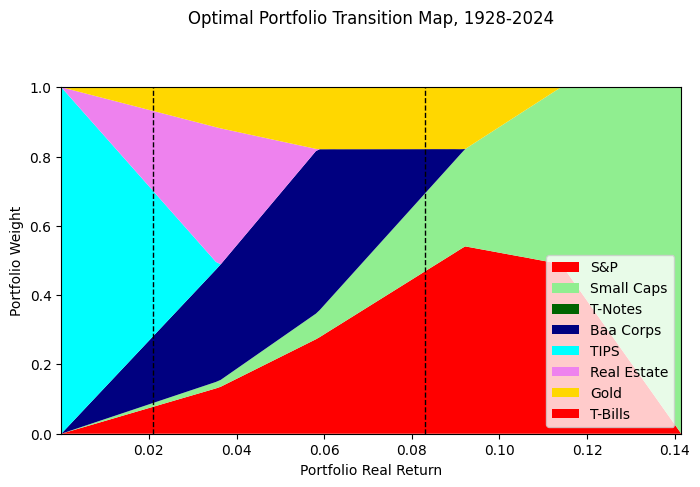

In [52]:
transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1], max_sharpe_return=max_sharpe_return, avg_ret_mean=avg_ret_mean)


# Long/short optimization with leverage constraint

In [53]:
x1 = real_data_df['S&P'].values
n = len(x1)
target_corr = 0.6
theta = np.arccos(target_corr)
mean_return = -0.05
x2 = np.random.normal(0, x1.std(), size=n)  
# center so actual mean = 0
X = pd.DataFrame({'x1': x1 - x1.mean(),
                  'x2': x2 - x2.mean()
                 })
# identity matrix
Id = np.diag(np.ones(n))
# QR factorization 
Q, R = np.linalg.qr(X[['x1']])
P = Q @ Q.T
x2o = (Id - P) @ X[['x2']]
Xc2 = pd.DataFrame({'x1': X['x1'], 'x2': x2o['x2']})
# divide by l2 norm
Y = Xc2 / np.sqrt(np.sum(np.square(Xc2), axis=0))
retval = Y['x2'] + (1/np.tan(theta)) * Y['x1'] + mean_return


In [54]:
# in order to include shorts, we need an asset with a poor expected return
# assume I can identify bad stocks, they are highly correlated with S&P but return negative 5%
# create a synthetic 'shorts' asset 

n = len(real_data_df)
target_corr = 0.6
def target_corr(x1, target_corr, mean_return):
    """given a series x1, return a random series with correlation target_corr to x1"""
    n = len(x1)
    theta = np.arccos(target_corr)
    
    x2 = np.random.normal(0, x1.std(), size=n)  
    # center so actual mean = 0
    X = pd.DataFrame({'x1': x1 - x1.mean(),
                      'x2': x2 - x2.mean()
                     })
    # identity matrix
    Id = np.diag(np.ones(n))
    # QR factorization
    Q = np.linalg.qr(X[['x1']])[0]
    P = Q @ Q.T
    x2o = (Id - P) @ X[['x2']]
    Xc2 = pd.DataFrame({'x1': X['x1'], 'x2': x2o['x2']})
    # divide by l2 norm
    Y = Xc2 / np.sqrt(np.sum(np.square(Xc2), axis=0))
    return Y['x2'] + (1/np.tan(theta)) * Y['x1'] + mean_return

shorts = target_corr(real_data_df['S&P'].values, 0.9, -0.05)
print("mean return %.04f" % shorts.mean())
print("vol %.04f" % shorts.std())
np.corrcoef(shorts, real_data_df['S&P'])



mean return -0.0500
vol 0.2341


array([[1. , 0.9],
       [0.9, 1. ]])

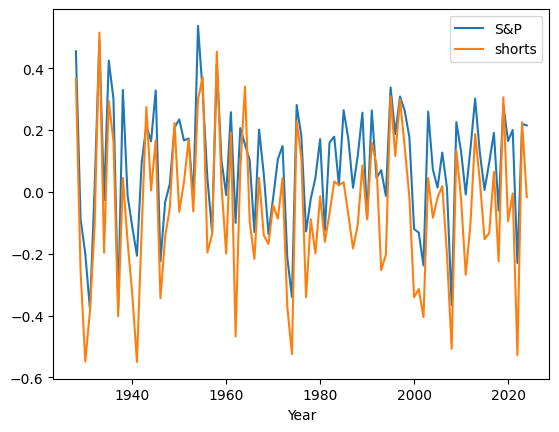

In [55]:
df = real_data_df.copy()
df['shorts'] = shorts.to_list()
labels = ['S&P', 'Small Caps', 'Real Estate', 'T-Bills', 'T-Notes', 'Gold', 'Baa Corps', 'shorts']

df[['S&P', 'shorts']].plot.line();

In [56]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,Small Caps,Real Estate,T-Bills,T-Notes,Gold,Baa Corps,shorts
rows,,,,,,,,
real return,0.085485,0.141503,0.003392,0.018030,0.038531,0.012791,0.034768,-0.050000
vol,0.193954,0.372034,0.038017,0.088987,0.088440,0.049934,0.186131,0.234146


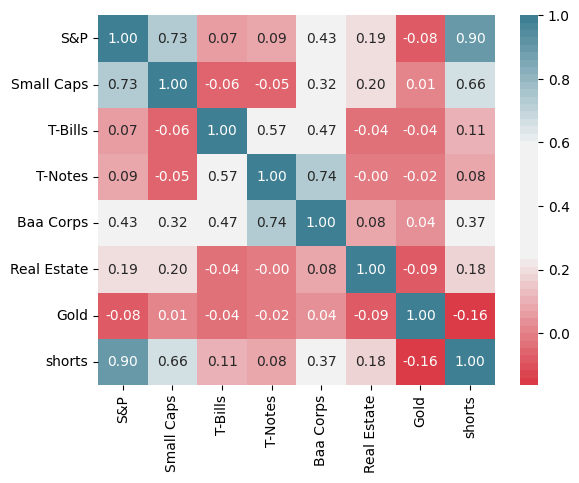

In [57]:
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(df.corr(), annot=True, fmt=".02f", cmap=my_cmap);


In [58]:
# Solve max return portfolio (corner solution)
# update constraints for leverage scenario
# sum of weights == 1 as before, net long 100%
# remove w >= 0 constraint
# new constraint on gross exposure <= 1.5, otherwise optimal weights are unbounded (go infinity long S&P, infinity short stonks)

prob = cp.Problem(cp.Maximize(ret), 
                  [cp.norm1(w) <= 1.5,
                   cp.sum(w) == 1]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights (return=%.4f, vol=%.4f)" % (maxret, maxretvol))
pd.DataFrame([wts], columns=labels)


Max return portfolio weights (return=0.1894, vol=0.1839)


,S&P,Small Caps,Real Estate,T-Bills,T-Notes,Gold,Baa Corps,shorts
0,0.0,1.25,0.0,0.0,0.0,0.0,0.0,-0.25


In [59]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.norm1(w) <= 1.5,
                   cp.sum(w) == 1]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights (return=%.4f, vol=%.4f)" % (minvolret, minvol))
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights (return=0.0110, vol=0.0008)


,S&P,Small Caps,Real Estate,T-Bills,T-Notes,Gold,Baa Corps,shorts
0,0.0379,0.0009,0.674,-0.0369,-0.0328,0.354,0.0336,-0.0307


In [60]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret), 
                  [cp.norm1(w) <= 1.5,
                   cp.sum(w) == 1,
                   vol <= vol_limit]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(np.sqrt(minvol), np.sqrt(maxretvol), NPOINTS)
vl_vals = np.square(vl_vals)
# vol constraint is in variance space, take square root of minvol and maxvol, linspace, square values)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 308 ms, sys: 2.96 ms, total: 311 ms
Wall time: 106 ms


In [61]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
# ret_df


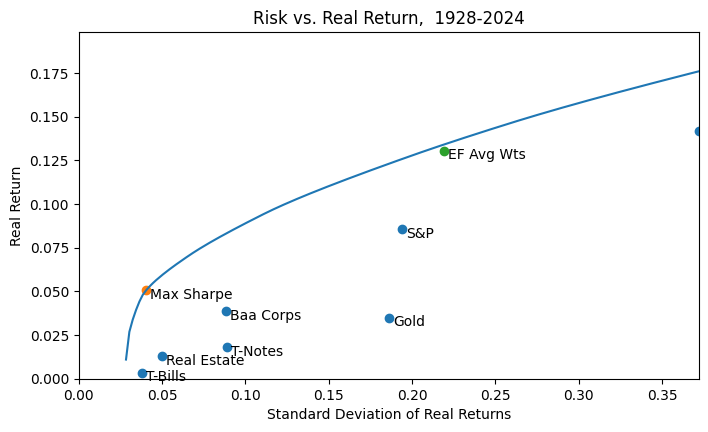

Max Sharpe Portfolio:
Real Return: 5.06%
SD:          4.04%
T-Bills: 0.0%
Real Estate: 47.9%
T-Notes: 4.6%
Baa Corps: 3.6%
Gold: 35.9%
S&P: 31.7%
Small Caps: 1.2%
shorts: -25.0%

Average over efficient frontier:
Real Return: 13.05%
SD:          21.90%
T-Bills: -0.1%
Real Estate: 3.4%
T-Notes: 10.5%
Baa Corps: 6.4%
Gold: 5.8%
S&P: 50.8%
Small Caps: 48.0%
shorts: -24.8%
Real Return: 13.05%
SD:          21.90%


In [62]:
max_sharpe_return, max_sharpe_std, avg_ret_mean, avg_ret_std = plot_efrontier(ret_df, df)
# note that in practice, due to 150% gross exposure the return and SD would be 50% higher 
# as a percentage of assets under management
# 7.5% return on 6% volatility looks pretty good vs. long-only portfolios 

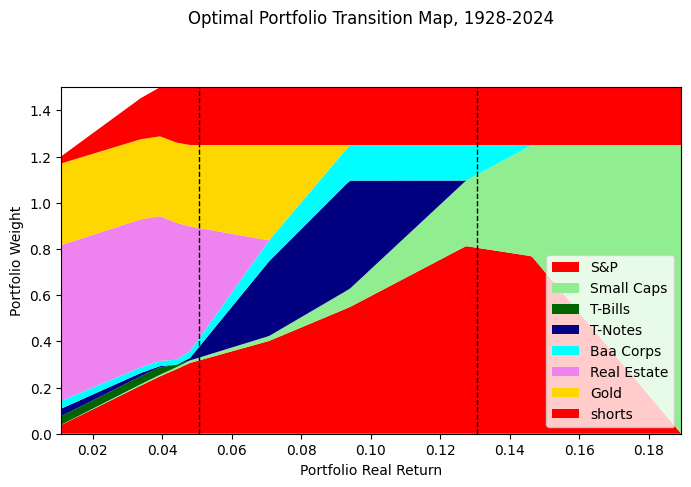

In [63]:
transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1], max_sharpe_return=max_sharpe_return, avg_ret_mean=avg_ret_mean, ylim=1.5)
# these are absolute gross exposure values, not net exposure. may need debugging, left doesn't seem to sum to 1

# Alternative approaches

- If we thought returns were really IID log normally distributed and covariance stationary, then this optimization approach whould generate an optimal forward-looking efficient frontier.
- But we can see that there are regime changes so covariance stationarity isn't a very good assumption, nor is log normality.
- Since we might be overfitting to a particular past regime, we might want to regularize, which is to say back off from the model's maximum in a systematic way towards a more diversified solution robust to regime changes, while still near optimal.
- A few regularization approaches with thanks to [Roman Rubsamen and PortfolioOptimizer.io](https://portfoliooptimizer.io):
    - [Near optimal portfolios](https://portfoliooptimizer.io/blog/mean-variance-optimization-in-practice-well-diversified-near-efficient-portfolios/) One approach is, first find the highest Sharpe portfolio. Then we can say, find the lowest risk portfolio with no more than e.g. a 0.05 drop in Sharpe ratio. Since this portfolio is more diversified, i.e. most diversified within 0.05 of maximum Sharpe, it should be more robust out-of-sample.
    - [Subset resampled portfolios](https://portfoliooptimizer.io/blog/mean-variance-optimization-in-practice-subset-resampling-based-efficient-portfolios/), Suppose we have 6 assets, do 6 optimizations, dropping one asset each time, then average all the portfolios. Similar to random forest, an ensemble of slightly weakened models performs better out of sample than a single overfitted model.
    - [Michaud resampling](https://docs.portfoliooptimizer.io/index.html#post-/portfolios/analysis/mean-variance/efficient-frontier/resampling-based) and [MCOS](https://github.com/enjine-com/mcos/tree/master). Do Monte Carlo simulations where we perturb the return forecasts and covariances randomly each time, and average all the resulting portfolios. 
    - [Hierarchical Risk Parity](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2708678) and related methods like Nested Cluster Optimization. Create a tree of assets clustered by similarity. Then starting at the bottom at each non-leaf create a risk parity portfolio of assets under the node, and recursively climb the tree to get a global portfolio. If you create an portfolio of t-bonds and notes and bills and corporates (NCO) and MBS and munis, we will get some of each, even if one is dominated under MV optimization. Same if you do US stocks and various international of various market caps and geographies. Then as you combine clusters, all asset classes are represented, whereas a global optimization might omit some assets. Vanilla HRP actually ignores returns and correlations, uses only variances, and creates a minimum risk portfolio assuming no covariance at each level.
    - Or the naive approach above, where we just average over the entire efficient frontier. One could do something more systematic and test how much regularization works best out of sample.

# Hierarchical risk parity

- Using the correlation matrix we can cluster assets into similar clusters and put equal risk into each cluster
  - Use agglomerative clustering to make a binary tree of assets
  - Start at individual assets, combine the 2 most correlated into a cluster
  - Continue iteratively combining the most correlated assets or clusters into bigger clusters, until you arrive at the root.
  - Now starting at the leaf nodes, allocate each asset to its parent cluster in inverse proportion to variance, and continue iteratively up the tree.
  - A heuristic way to create a low variance portfolio, but unlike the minimum-variance optimization it's not very sensitive to small changes in correlations and doesn't use a return forecast. Kind of a poor man's minimum variance portfolio.
    

In [64]:
# 1928-present
df = real_data_df.loc[1928:].copy()
labels = df.columns


In [65]:
# show returns and vols 
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
rows,,,,,,,
real return,0.085485,0.141503,0.003392,0.018030,0.038531,0.012791,0.034768
vol,0.193954,0.372034,0.038017,0.088987,0.088440,0.049934,0.186131


In [66]:
# Building a Riskfolio portfolio object
port = rp.HCPortfolio(returns=df)

# Estimate optimal portfolio:

model='HRP' 
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage_method = 'single' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage_method,
                      max_k=max_k,
                      leaf_order=leaf_order)
display(w.T)
# concentrated but should be less concentrated than minimum variance portfolio which is:
# 	S&P	Real Estate	T-Bills	T-Notes	Gold	Baa Corps
# 	0.001076	0.361574	0.599897	-0.0	0.037453	-0.0


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
weights,0.016239,0.005558,0.476536,0.086978,0.0781,0.308555,0.028033


In [67]:
# Nested Cluster Optimization
df = df.loc[1928:]
labels = df.columns

# Building the portfolio object
port = rp.HCPortfolio(returns=df)

# Estimate optimal portfolio:

model='NCO' 
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage_method = 'single' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage_method,
                      max_k=max_k,
                      leaf_order=leaf_order)
display(w.T)  # more concentrated than HRP

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
weights,6.222206e-10,0.00054,0.605444,2.745760e-10,3.477368e-10,0.357285,0.036731


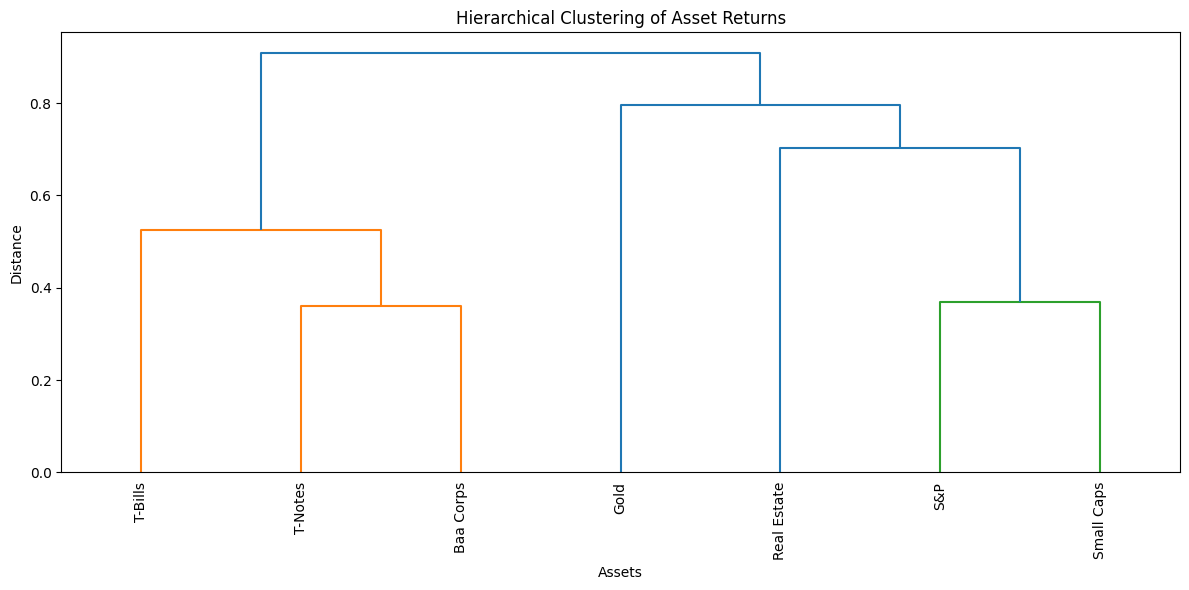

In [68]:
# compute HRP ourselves instead using riskfolio module

def cov_to_corr(cov):
    """Convert covariance matrix to correlation matrix."""
    if not np.allclose(cov, cov.T):  # check symmetry
        raise ValueError("Covariance matrix is not symmetric")
    sd = np.sqrt(np.diag(cov)) # covariance to SD
    corr = cov / np.outer(sd, sd) # scale cov[i,j] by dividing by sd[i[*sd[j] to get correlation
    # fix some numerical precision errors
    # Use isclose to fix values close to 0
    corr[np.isclose(corr, 0, atol=1e-9)] = 0
    # ensure not > 1 or < -1
    corr = np.clip(corr, -1, 1)  
    return corr

def get_correlation_dist(corr):
    """Convert covariance matrix to a correlation distance matrix."""
    dist = np.sqrt((1 - corr)/2)
    dist = np.clip(dist, 0, None)      # fix numerical precision errors, dist never <0
    np.fill_diagonal(dist.values, 0)
    return dist

def show_dendrogram(linkage, labels):
    plt.figure(figsize=(12, 6))
    dendrogram(linkage,
               labels=labels,
               orientation='top',
               leaf_rotation=90,
               leaf_font_size=10,
               show_contracted=True
              )
    plt.title('Hierarchical Clustering of Asset Returns')
    plt.xlabel('Assets')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

# Calculate covariance matrix
covariance_matrix = df.cov()
# use Ledoit-Wolf robust covariance when more than 30 or so assets (cols = 30% of rows)
# Ledoit-Wolf is a cross between full covariance matrix and the one that would be generated by a single-factor beta model
# lw = LedoitWolf()
# covariance_matrix = pd.DataFrame(lw.fit(df).covariance_, index=df.columns, columns=df.columns)

correlation_matrix = cov_to_corr(covariance_matrix)
distance_matrix = get_correlation_dist(correlation_matrix)
# 'ward' method tends to create balanced clusters. original de Prado paper used single linkage
# riskfolio uses ward
# need to study this more, you want to balance max between-cluster distance and min within-cluster distance
# Ward's method: minimizes distance within clusters (need to understand how it avoids single element clusters with 0 distance)
# Single linkage (nearest point): minimum distance between any 2 members
# Complete linkage (furthest point): maximum distance between any members (ok but once you put farthest points in distinct clusters how to you determine the others)
# Average linkage: average distance between all members

link = linkage(squareform(distance_matrix), method='ward')
show_dendrogram(link, df.columns.tolist())

In [69]:
leaves_list(link)

array([2, 3, 4, 6, 5, 0, 1], dtype=int32)

In [70]:
df.columns[leaves_list(link)]

Index(['T-Bills', 'T-Notes', 'Baa Corps', 'Gold', 'Real Estate', 'S&P',
       'Small Caps'],
      dtype='object')

In [71]:
correlation_matrix

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
S&P,1.000000,0.728997,0.066355,0.089967,0.429671,0.190788,-0.082034
Small Caps,0.728997,1.000000,-0.061354,-0.046973,0.316524,0.195721,0.012048
T-Bills,0.066355,-0.061354,1.000000,0.567545,0.473468,-0.038676,-0.035114
T-Notes,0.089967,-0.046973,0.567545,1.000000,0.739134,-0.002498,-0.016374
Baa Corps,0.429671,0.316524,0.473468,0.739134,1.000000,0.078462,0.040781
Real Estate,0.190788,0.195721,-0.038676,-0.002498,0.078462,1.000000,-0.087687
Gold,-0.082034,0.012048,-0.035114,-0.016374,0.040781,-0.087687,1.000000


In [72]:
ordered_indices = leaves_list(link)
# reorder everything
correlation_matrix = correlation_matrix.iloc[ordered_indices, ordered_indices]
covariance_matrix = covariance_matrix.iloc[ordered_indices, ordered_indices]
distance_matrix = distance_matrix.iloc[ordered_indices, ordered_indices]
df = df.iloc[:, ordered_indices].copy()


In [73]:
correlation_matrix

,T-Bills,T-Notes,Baa Corps,Gold,Real Estate,S&P,Small Caps
T-Bills,1.000000,0.567545,0.473468,-0.035114,-0.038676,0.066355,-0.061354
T-Notes,0.567545,1.000000,0.739134,-0.016374,-0.002498,0.089967,-0.046973
Baa Corps,0.473468,0.739134,1.000000,0.040781,0.078462,0.429671,0.316524
Gold,-0.035114,-0.016374,0.040781,1.000000,-0.087687,-0.082034,0.012048
Real Estate,-0.038676,-0.002498,0.078462,-0.087687,1.000000,0.190788,0.195721
S&P,0.066355,0.089967,0.429671,-0.082034,0.190788,1.000000,0.728997
Small Caps,-0.061354,-0.046973,0.316524,0.012048,0.195721,0.728997,1.000000


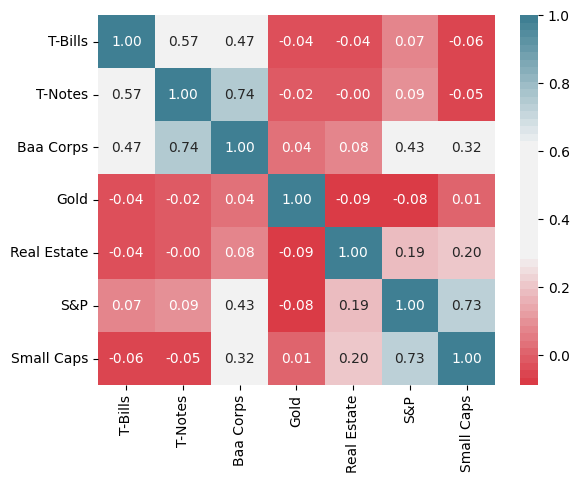

In [74]:
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(correlation_matrix, annot=True, fmt=".02f", cmap=my_cmap);
# can't help feeling corps should come before T-Notes, seems more correlated with S&P so WTF

In [75]:
# Example linkage array
# [[1, 3, 0.3, 2],    # Merge observations 1 & 3, distance=0.3, size=2 - create observation 4
#  [0, 4, 0.4, 3],    # Merge observations 0 & 4 (from step 1), distance=0.4, size=2 - create observation 5
#  [2, 5, 0.6, 4]]    # Merge observations 2 & 5 (from step 2), distance=0.6, size=3

# create a linkage array based on bisection
# basically throw out the tree and just make one based on the sort order that falls out of the linkage array
# this is how it was done in the original paper but frankly, we already have a tree that contains good info 
# so I don't really understand why we wouldn't just use that.
# writing this code so we can go either way
# this will merge corps and T-notes, then stocks and gold, then merge both clusters.

def recursive_bisection(corr_matrix):
    """
    Perform recursive bisection on correlation matrix and return linkage-like structure
    Returns array with format similar to scipy.cluster.hierarchy.linkage:
    [[cluster1, cluster2, distance, size], ...]
    Really doesn't matter that the values are correlations, just uses the row/column order
    """
    n_children = len(corr_matrix)
    # Initialize with individual assets as clusters
    # Will store our linkage-like information
    bisection_links = []
    last_index = 0
    
    def split_cluster(cluster_indices):
        n_children = len(cluster_indices)
        if n <= 1:
            return cluster_indices
        else:
            split = n_children // 2
            return cluster_indices[split:], cluster_indices[:split]
    
    # Start with all assets in one cluster
    queue = [list(range(n_children))]
    
    while queue:
        current_cluster = queue.pop(0)
        if len(current_cluster) <= 1:
            continue
            
        # Split cluster
        cluster1, cluster2 = split_cluster(current_cluster)
        
        # Calculate distance (1 - avg correlation between clusters)
        avg_corr = corr_matrix.iloc[cluster1, cluster2].mean().mean()
        distance = 1 - avg_corr
        
        # Add to linkage-like structure
        if len(cluster1) > 1:
            cluster1_index = last_index - 1
            last_index = cluster1_index
        elif len(cluster1) == 1:
            cluster1_index = cluster1[0]
        else:
            print("error in bisection")
            
        if len(cluster2) > 1:
            cluster2_index = last_index - 1
            last_index = cluster2_index
        elif len(cluster2) == 1:
            cluster2_index = cluster2[0]
        else:
            print("error in bisection")

        bisection_links.append([
            cluster1_index, cluster2_index,  # use minimum index from each cluster
            distance,
            len(cluster1) + len(cluster2)
        ])
        
        # Add new clusters to queue if they're larger than 1
        if len(cluster1) > 1:
            queue.append(cluster1)
        if len(cluster2) > 1:
            queue.append(cluster2)

    n_new_clusters = -last_index
    highest_cluster_number = n_children + n_new_clusters - 1
    retarray = []
    for a in bisection_links:
        cluster1_index = highest_cluster_number + a[0] + 1 if a[0] < 0 else a[0]
        cluster2_index = highest_cluster_number + a[1] + 1 if a[1] < 0 else a[1]
        retarray.append([
            cluster1_index, cluster2_index,  # use minimum index from each cluster
            a[2],
            a[3]
        ])
    return list(reversed(retarray))

bisection_links = recursive_bisection(correlation_matrix)

bisection_links

[[2, 1, 0.2608664380976916, 2],
 [4, 3, 1.0876869748099514, 2],
 [6, 5, 0.2710028105531145, 2],
 [7, 0, 0.47949354756382445, 3],
 [9, 8, 0.9208692647881316, 4],
 [11, 10, 0.9316024846740261, 7]]

In [76]:
# Create a 12x12 DataFrame of random numbers between -1 and 1
# random_df = pd.DataFrame(np.random.uniform(-1, 1, size=(12, 12)))

def recursive_bisection(corr_matrix):
    """
    Perform recursive bisection on ordered correlation matrix and return linkage-like structure.
    Returns array with format similar to scipy.cluster.hierarchy.linkage:
    [[cluster1, cluster2, distance, size], ...]
    """
    n = len(corr_matrix)
    bisection_links = []
    next_cluster_id = n
    
    def split_cluster(indices):
        """Split cluster into two parts based on current order"""
        mid = len(indices) // 2
        return indices[:mid], indices[mid:]
    
    def process_cluster(indices):
        """Recursively process clusters and build linkage structure"""
        if len(indices) <= 1:
            return indices[0]
            
        # Split cluster
        left_indices, right_indices = split_cluster(indices)
        
        # Process sub-clusters recursively
        left_id = process_cluster(left_indices) if len(left_indices) > 0 else None
        right_id = process_cluster(right_indices) if len(right_indices) > 0 else None
        
        # Calculate distance (1 - avg correlation between clusters)
        avg_corr = corr_matrix.iloc[left_indices, right_indices].mean().mean()
        distance = 1 - avg_corr
        
        # Add to linkage structure
        nonlocal next_cluster_id
        bisection_links.append([
            left_id,
            right_id,
            distance,
            len(left_indices) + len(right_indices)
        ])
        
        cluster_id = next_cluster_id
        next_cluster_id += 1
        return cluster_id
    
    # Start recursive process with all indices
    process_cluster(list(range(n)))
    
    return np.array(bisection_links)

# Example usage:
bisection_links = recursive_bisection(correlation_matrix)  # use the already ordered correlation matrix
print("Bisection linkage structure:")
print(bisection_links)


Bisection linkage structure:
[[ 1.          2.          0.26086644  2.        ]
 [ 0.          7.          0.47949355  3.        ]
 [ 3.          4.          1.08768697  2.        ]
 [ 5.          6.          0.27100281  2.        ]
 [ 9.         10.          0.92086926  4.        ]
 [ 8.         11.          0.93160248  7.        ]]


In [77]:
def calculate_hrp_weights(link, cov_matrix):
    """
    Calculate HRP portfolio weights using linkage structure
    
    Parameters:
    -----------
    link : numpy.ndarray
        Linkage matrix with shape (n-1, 4) where n is number of assets
    cov_matrix : pandas.DataFrame
        Covariance matrix of asset returns
        
    Returns:
    --------
    pandas.Series
        Portfolio weights indexed by asset names
    """
    # Input validation
    if not isinstance(cov_matrix, pd.DataFrame):
        raise TypeError("cov_matrix must be a pandas DataFrame")
    if not np.allclose(cov_matrix, cov_matrix.T):
        raise ValueError("cov_matrix must be symmetric")
    if link.shape[1] != 4:
        raise ValueError("link must have 4 columns (cluster1, cluster2, distance, size)")
    
    def cluster_variance(cluster_assets):
        """Calculate variance of a cluster using equal weights"""
        cluster_cov = cov_matrix.iloc[cluster_assets, cluster_assets]
        w = np.ones(len(cluster_assets)) / len(cluster_assets)
        variance = np.transpose(w) @ cluster_cov @ w
        return max(0, variance) # numerical stability check, force non-neg

    n = len(cov_matrix)
    weights = np.ones(n)
    
    # Initialize clusters dictionary: at start, each asset is in its own cluster
    clusters = {i: [i] for i in range(n)}
    
    # Process each merge from the linkage
    for i, row in enumerate(link):
        cluster1_idx = int(row[0])
        cluster2_idx = int(row[1])
        new_cluster_idx = n + i
        
        # Get assets in each cluster
        cluster1_assets = clusters[cluster1_idx]
        cluster2_assets = clusters[cluster2_idx]
        
        # Calculate cluster variances
        var1 = cluster_variance(cluster1_assets)
        var2 = cluster_variance(cluster2_assets)
        
        # Calculate weights
        alpha = 1 - (var1 / (var1 + var2))
        
        # Update weights
        for idx in cluster1_assets:
            weights[idx] *= alpha
        for idx in cluster2_assets:
            weights[idx] *= (1 - alpha)
        
        # Store the merged cluster
        clusters[new_cluster_idx] = cluster1_assets + cluster2_assets
        
        # Verify cluster size matches linkage info
        if len(clusters[new_cluster_idx]) != int(row[3]):
            raise ValueError(f"Cluster size mismatch at step {i}")    
            
    # Normalize weights
    weights = weights / np.sum(weights)
    
    return pd.Series(weights, index=cov_matrix.index)

calculate_hrp_weights(bisection_links, covariance_matrix)

# doesn't match riskfolio
# S&P	T-Notes	Gold	Baa Corps
# weights	0.110835	0.311695	0.167578	0.409892

# matches pretty close if leaf_order = False
# 	S&P	T-Notes	Gold	Baa Corps
# weights	0.182752	0.225961	0.222854	0.368433

# TODO : look up how riskfolio enforces leaf order

T-Bills        0.689749
T-Notes        0.072387
Baa Corps      0.073283
Gold           0.009811
Real Estate    0.136320
S&P            0.014507
Small Caps     0.003943
dtype: float64

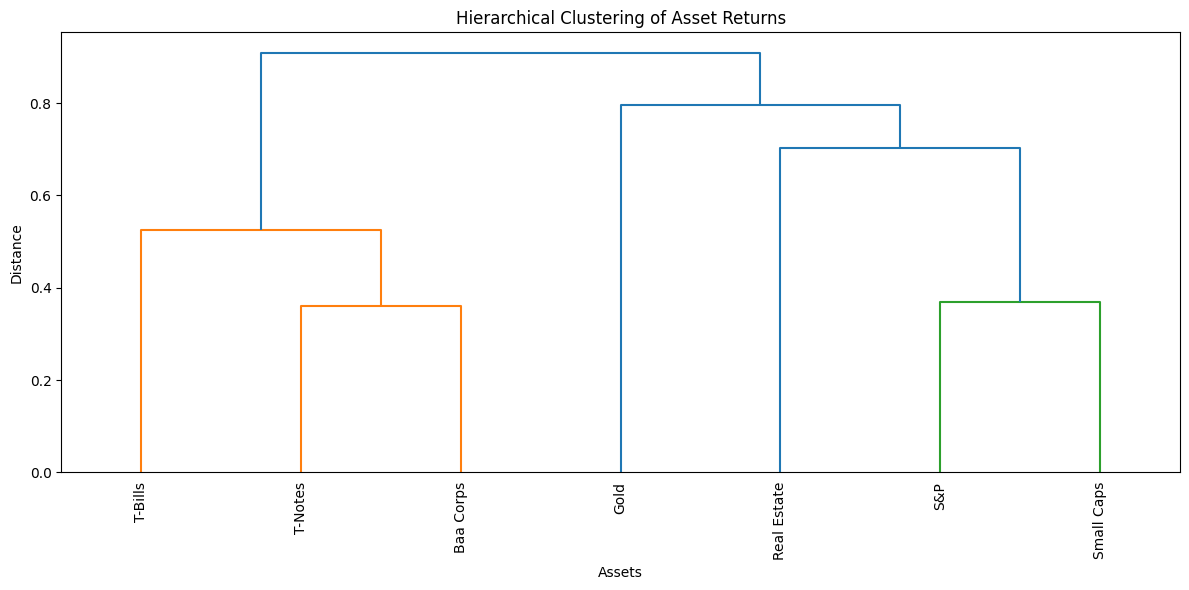

In [78]:
# redo this without bisecting, just use the tree created in the agglomerative clustering step.
# reorder df

# Calculate covariance matrix
covariance_matrix = df.cov()
# use Ledoit-Wolf robust covariance when more than 30 or so assets (cols = 30% of rows)
# Ledoit-Wolf is a cross between full covariance matrix and the one that would be generated by a single-factor beta model
# lw = LedoitWolf()
# covariance_matrix = pd.DataFrame(lw.fit(df).covariance_, index=df.columns, columns=df.columns)

correlation_matrix = cov_to_corr(covariance_matrix)
distance_matrix = get_correlation_dist(correlation_matrix)
# 'ward' method tends to create balanced clusters. original paper used single linkage
# riskfolio uses ward
# need to study this more, you want to balance max between-cluster distance and min within-cluster distance
# Ward's method: minimizes distance within clusters (need to understand how it avoids single element clusters with 0 distance)
# Single linkage (nearest point): minimum distance between any 2 members
# Complete linkage (furthest point): maximum distance between any members (ok but once you put farthest points in distinct clusters how to you determine the others)
# Average linkage: average distance between all members

link = linkage(squareform(distance_matrix), method='ward')
show_dendrogram(link, df.columns.tolist())


In [79]:
calculate_hrp_weights(link, covariance_matrix)
# more gold because merge is 2,3,4 instead fo 2,2,4

T-Bills        0.689749
T-Notes        0.072387
Baa Corps      0.073283
Gold           0.079969
Real Estate    0.081714
S&P            0.002279
Small Caps     0.000619
dtype: float64

# Max Sharpe using portfoliooptimizer.io

In [80]:
# load API key for portfoliooptimizer.io
dotenv.load_dotenv()


True

In [81]:
# 1928-present
df = real_data_df.loc[1928:].copy()
labels = df.columns
n_years, n_assets = df.shape


In [82]:
mu = df.mean().to_list()
covmatrix = df.cov().values


In [83]:
# API endpoint and headers
BASEURL = "https://api.portfoliooptimizer.io/v1"
ENDPOINT = "portfolio/optimization/maximum-sharpe-ratio"
url = f"{BASEURL}/{ENDPOINT}"
print(url)

headers = {
    "Content-Type": "application/json",
    "Authorization": f'Bearer {os.getenv("PORTFOLIO_OPT_APIKEY")})'
}

# Payload
data = {
    "assets": n_assets,
    "assetsReturns": mu,
    "assetsCovarianceMatrix": covmatrix.tolist(),
    "riskFreeRate": 0
}

# Make the POST request
response = requests.post(url, json=data, headers=headers)

# Check and print the response
if response.status_code == 200:
    print("Response data:", response.json())
else:
    print("Error:", response.status_code, response.text)
   

https://api.portfoliooptimizer.io/v1/portfolio/optimization/maximum-sharpe-ratio
Response data: {'assetsWeights': [0.13383517577722553, 0.019061484298140426, 0, 0, 0.3316896097286149, 0.39743704417404285, 0.11797668602197646]}


In [84]:
wts = json.loads(response.text)['assetsWeights']
pd.DataFrame({'Asset': df.columns.to_list(), 'Weight': wts})
# pretty close to above, note that we slice into 200 variances so discretization will impact it a little 

# Max Sharpe Portfolio:
# Real Return: 3.63%
# SD:          6.16%
# T-Bills: 0.0%
# Real Estate: 39.3%
# T-Notes: 0.0%
# Baa Corps: 33.3%
# Gold: 11.9%
# S&P: 13.5%
# Small Caps: 2.0%

,Asset,Weight
0,S&P,0.133835
1,Small Caps,0.019061
2,T-Bills,0.000000
3,T-Notes,0.000000
4,Baa Corps,0.331690
5,Real Estate,0.397437
6,Gold,0.117977


In [85]:
port_returns = df @ wts
print(f"Mean return: {100*port_returns.mean():3.2f}%")
print(f"Vol          {100*port_returns.std():3.2f}%")


Mean return: 3.61%
Vol          6.12%


# Near optimal diversified

[Near optimal portfolios](https://portfoliooptimizer.io/blog/mean-variance-optimization-in-practice-well-diversified-near-efficient-portfolios/) 

First find the highest Sharpe portfolio. Then, find the lowest risk portfolio with no more than e.g. a 0.05 drop in Sharpe ratio. Since this portfolio is more diversified, i.e. most diversified within 0.05 of maximum Sharpe, it should be more robust out-of-sample.


In [86]:
# 1928-present
df = real_data_df.loc[1928:].copy()
labels = df.columns
n_years, n_assets = df.shape


In [87]:
mu = df.mean().to_list()
covmatrix = df.cov().values


In [88]:
# docs
# https://docs.portfoliooptimizer.io/index.html#post-/portfolio/optimization/maximum-sharpe-ratio/diversified

# API endpoint and headers
BASEURL = "https://api.portfoliooptimizer.io/v1"
ENDPOINT = "portfolio/optimization/maximum-sharpe-ratio/diversified"
url = f"{BASEURL}/{ENDPOINT}"
print(url)

headers = {
    "Content-Type": "application/json",
    "Authorization": f'Bearer {os.getenv("PORTFOLIO_OPT_APIKEY")})'
}

# Payload
# I'm surprised there is no parameter for how 'near' is considered 'near optimal'

data = {
    "assets": n_assets,
    "assetsReturns": mu,
    "assetsCovarianceMatrix": covmatrix.tolist(),
    "riskFreeRate": 0
}

# Make the POST request
# time.sleep(1) # can max out rate limit when run end to end

response = requests.post(url, json=data, headers=headers)

# Check and print the response
if response.status_code == 200:
    print("Response data:", response.json())
else:
    print("Error:", response.status_code, response.text)
    

https://api.portfoliooptimizer.io/v1/portfolio/optimization/maximum-sharpe-ratio/diversified
Response data: {'assetsWeights': [0.1211902217456536, 0.07236249865986982, 0.17185104875327442, 0.16176449186650416, 0.15224295250609796, 0.17138257603260965, 0.14920621043599022]}


In [89]:
wts = json.loads(response.text)['assetsWeights']
pd.DataFrame({'Asset': df.columns.to_list(), 'Weight': wts})


,Asset,Weight
0,S&P,0.121190
1,Small Caps,0.072362
2,T-Bills,0.171851
3,T-Notes,0.161764
4,Baa Corps,0.152243
5,Real Estate,0.171383
6,Gold,0.149206


In [90]:
port_returns = df @ wts
print(f"Mean return: {100*port_returns.mean():3.1f}%")
print(f"Vol          {100*port_returns.std():3.1f}%")
     
# weights are very equally balanced 
# should try running explicitly indiv portfolios and averaging


Mean return: 3.7%
Vol          6.7%


# Subset Resampling

[Subset resampled portfolios](https://portfoliooptimizer.io/blog/mean-variance-optimization-in-practice-subset-resampling-based-efficient-portfolios/), Suppose we have 6 assets, do 6 optimizations, dropping one asset each time, then average all the portfolios. Similar to random forest, an ensemble of slightly weakened models is better than a single overfitted model.
    

In [91]:
# 1928-present
df = real_data_df.loc[1928:].copy()
df["TIPS"] = 0
labels = df.columns
n_years, n_assets = df.shape


In [92]:
mu = df.mean().to_list()
covmatrix = df.cov().values


In [93]:
# API endpoint and headers
BASEURL = "https://api.portfoliooptimizer.io/v1"
ENDPOINT = "portfolio/optimization/maximum-sharpe-ratio/subset-resampling-based"
url = f"{BASEURL}/{ENDPOINT}"
print(url)

headers = {
    "Content-Type": "application/json",
    "Authorization": f'Bearer {os.getenv("PORTFOLIO_OPT_APIKEY")})'
}

# Payload
data = {
    "assets": n_assets,
    "assetsReturns": mu,
    "assetsCovarianceMatrix": covmatrix.tolist(),
    "riskFreeRate": 0
}

# Make the POST request
# time.sleep(1) # can max out rate limit when run end to end
response = requests.post(url, json=data, headers=headers)

# Check and print the response
if response.status_code == 200:
    print("Response data:", response.json())
else:
    print("Error:", response.status_code, response.text)
    

https://api.portfoliooptimizer.io/v1/portfolio/optimization/maximum-sharpe-ratio/subset-resampling-based
Response data: {'assetsWeights': [0.1443943814931611, 0.07506839434889616, 0.1046061162676192, 0.11589766594241249, 0.17691490733135962, 0.13805973645651362, 0.06336621467418284, 0.18169258348585487]}


In [94]:
wts = json.loads(response.text)['assetsWeights']
pd.DataFrame({'Asset': df.columns.to_list(), 'Weight': wts})


,Asset,Weight
0,S&P,0.144394
1,Small Caps,0.075068
2,T-Bills,0.104606
3,T-Notes,0.115898
4,Baa Corps,0.176915
5,Real Estate,0.138060
6,Gold,0.063366
7,TIPS,0.181693


In [95]:
port_returns = df @ wts
print(f"Mean return: {100*port_returns.mean():3.1f}%")
print(f"Vol          {100*port_returns.std():3.1f}%")


Mean return: 3.6%
Vol          6.6%


# Michaud Resampling


[Michaud resampling](https://docs.portfoliooptimizer.io/index.html#post-/portfolios/analysis/mean-variance/efficient-frontier/resampling-based) and [MCOS](https://github.com/enjine-com/mcos/tree/master). Do Monte Carlo simulations where we perturb the return forecasts and covariances randomly each time, and average all the resulting portfolios. 


In [96]:
# 1928-present
df = real_data_df.loc[1928:].copy()
df["TIPS"] = 0
labels = df.columns
n_years, n_assets = df.shape


In [97]:
mu = df.mean().to_list()
covmatrix = df.cov().values


In [98]:
# make intervals for mus , maybe should be a multiple of sds, not sure
mu_adjust = [m/3 for m in mu]
mu_adjust = [max(0.01, m) for m in mu_adjust] # at least 1% uncertainty interval or 30%
mu_intervals = list(zip([mu[i] - mu_adjust[i] for i in range(len(mu))], 
                        [mu[i] + mu_adjust[i] for i in range(len(mu))]))
mu_intervals



[(0.056990319165406325, 0.11398063833081266),
 (0.09433554697967164, 0.1886710939593433),
 (-0.006607559079163135, 0.013392440920836865),
 (0.00803041655969365, 0.028030416559693648),
 (0.025687380368437283, 0.051374760736874574),
 (0.0027910992314479823, 0.02279109923144798),
 (0.023178797776483788, 0.04635759555296757),
 (-0.01, 0.01)]

In [99]:
# API endpoint and headers
BASEURL = "https://api.portfoliooptimizer.io/v1"
ENDPOINT = "portfolios/optimization/maximum-sharpe-ratio/resampling-based"
url = f"{BASEURL}/{ENDPOINT}"
print(url)

headers = {
    "Content-Type": "application/json",
    "Authorization": f'Bearer {os.getenv("PORTFOLIO_OPT_APIKEY")})'
}

# Payload
data = {
    "assets": n_assets,
    "assetsReturns": mu,
    "assetsReturnsUncertaintyIntervals": mu_intervals,
    "assetsCovarianceMatrix": covmatrix.tolist(),
    "riskFreeRate": 0,
#     "assetsCorrelationMatrixUncertaintyLevel": 0.25,
#     "portfolios": 100
}

# Make the POST request
# time.sleep(1) # can max out rate limit when run end to end

response = requests.post(url, json=data, headers=headers)

# Check and print the response
if response.status_code == 200:
    print("Response data:", response.json())
else:
    print("Error:", response.status_code, response.text)
    

https://api.portfoliooptimizer.io/v1/portfolios/optimization/maximum-sharpe-ratio/resampling-based
Response data: {'assetsWeights': [0.07692866017762388, 0.01830511309215745, 0.0649762082494252, 0.05742051474560366, 0.09586582343621397, 0.16588341307320628, 0.06386556579022525, 0.45675470143554425]}


In [100]:
wts = json.loads(response.text)['assetsWeights']
pd.DataFrame({'Asset': df.columns.to_list(), 'Weight': wts})


,Asset,Weight
0,S&P,0.076929
1,Small Caps,0.018305
2,T-Bills,0.064976
3,T-Notes,0.057421
4,Baa Corps,0.095866
5,Real Estate,0.165883
6,Gold,0.063866
7,TIPS,0.456755


In [101]:
port_returns = df @ wts
print(f"Mean return: {100*port_returns.mean():3.2f}%")
print(f"Vol:         {100*port_returns.std():3.2f}%")
print(f"Sharpe       {port_returns.mean()/ port_returns.std():3.2f}%")

    

Mean return: 1.85%
Vol:         3.20%
Sharpe       0.58%


# Factors

Optimal portfolio after decomposing returns into risk factors with PCA/SVD.


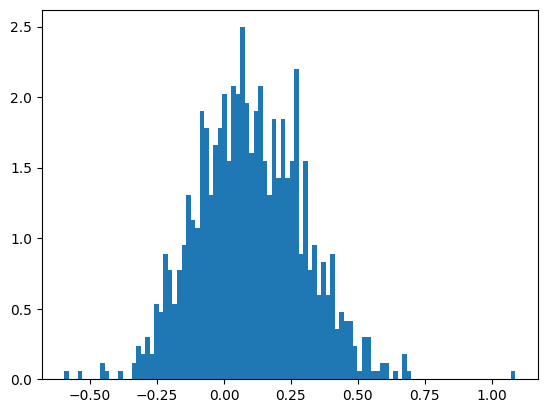

In [102]:
# we do this experiment with a synthetic portfolio
# number of stocks
n = 1000 
# historical mean returns for each stock
mu = np.random.normal(0.1, 0.2, n)

# number of factors
m = 10

# factor covariance matrix - random symmetrical matrix
SigmaFactor = np.random.randn(m, m)/4
SigmaFactor = SigmaFactor.T @ SigmaFactor

# factor loadings, determine volatility and covariances between stocks
F = np.random.randn(n, m)
# idiosyncratic risk of each stock
D = np.diag(np.random.uniform(0, 0.9, size=n))

count, bins, ignored = plt.hist(mu, 100, density=True, align='mid')


In [103]:
w = cp.Variable(n)         # what we solve for: weight for each stock
ret = mu.T @ w             # solve for weights that maximize portfolio return
f = F.T @ w                # portfolio factor loading
Lmax = cp.Parameter()      # leverage constraint
# portfolio volatility: factor risk + idiosyncratic risk
risk = cp.quad_form(f, SigmaFactor) + cp.quad_form(w, D)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   cp.norm(w, 1) <= Lmax])

# Solve the factor model problem.
Lmax.value = 2
prob.solve(verbose=True)

maxretvol = risk.value
maxret = ret.value
print("Max return portfolio (return=%.4f, vol=%.4f)" % (maxret, maxretvol))


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 16 11:23:26 PM: Your problem has 1000 variables, 2 constraints, and 1 parameters.
(CVXPY) Jan 16 11:23:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 16 11:23:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 16 11:23:26 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 16 11:23:26 PM: Compiling problem (target solver=CLARABEL).
(CVXPY) Jan 16 11:23:26 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY)

In [104]:
# solve min vol portfolio (other corner solution)

prob = cp.Problem(cp.Minimize(risk),
                  [cp.sum(w) == 1, 
                   cp.norm(w, 1) <= Lmax])
prob.solve(solver=cp.OSQP)

minvol = risk.value
minvolret = ret.value
print("Min vol portfolio (return=%.4f, risk=%.4f)" % (minvolret, minvol))


Min vol portfolio (return=0.1336, risk=0.0002)


In [105]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility
# might have to run a couple of times to get a solution

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   cp.norm(w, 1) <= Lmax,
                   risk <= vol_limit]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve(verbose=False)
    return (ret.value, np.sqrt(risk.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(np.sqrt(minvol), np.sqrt(maxretvol), NPOINTS)
vl_vals = np.square(vl_vals)
# vol constraint is in variance space, take square root of minvol and maxvol, linspace, square values)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 52 s, sys: 5.04 s, total: 57 s
Wall time: 7.85 s


In [106]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'var']
ret_df['return'] = [results_dict[v][0] for v in ret_df['var']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['var']]
# ret_df


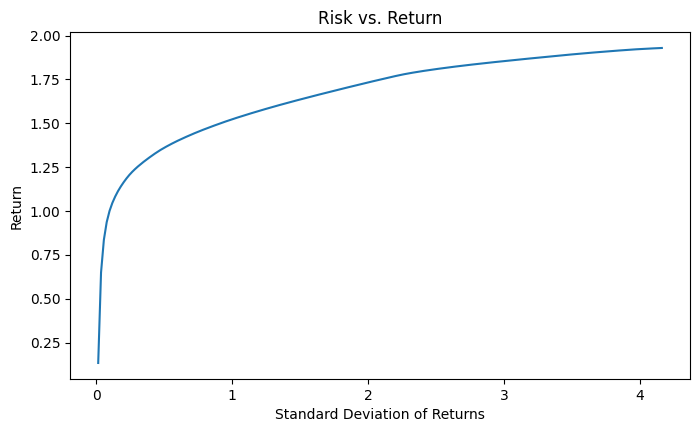

In [107]:
# plot frontier
plt.figure(figsize=(8, 4.5))
#plt.scatter(asset_vols, mu)

x = ret_df['std']
y = ret_df['return']
plt.xlabel("Standard Deviation of Returns")
plt.ylabel("Return")
plt.title("Risk vs. Return")

# plot the data
plt.plot(x,y);
